In [1]:
! pip install kaggle

In [2]:
!rm -rf /content/dataset

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.58G/3.58G [03:17<00:00, 20.8MB/s]
100% 3.58G/3.58G [03:17<00:00, 19.5MB/s]


!python --version

In [7]:
import torch
torch.__version__

'2.4.0+cu121'

In [8]:
! unzip fruits-fresh-and-rotten-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

In [9]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [11]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [12]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.7 MB/s eta 0:00:00


In [13]:
from urllib.request import urlopen
from PIL import Image
import timm

In [14]:
# from urllib.request import urlopen
# from PIL import Image
# import timm

# #pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
# pretrained_vit_weights = timm.create_model('vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True)

# pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# # Freezing the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False

# class_names = ['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

# set_seeds()
# pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import torch.nn as nn

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained model from timm
pretrained_vit = timm.create_model('vit_mediumd_patch16_reg4_gap_384.sbb2_e200_in12k_ft_in1k', pretrained=True).to(device)

# Freezing the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Define the number of classes
class_names = ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']

# Modify the final classification head to match the number of classes
# Adjusting the last layer to match the number of classes
in_features = pretrained_vit.head.in_features  # Get the number of input features for the final layer
pretrained_vit.head = nn.Linear(in_features, len(class_names)).to(device)

# Set seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Now your model is ready for training or evaluation


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/257M [00:00<?, ?B/s]

In [15]:
!pip install torchinfo

In [16]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 384, 384), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)    [32, 3, 384, 384]    [32, 6]              296,960              Partial
├─PatchEmbed (patch_embed)               [32, 3, 384, 384]    [32, 576, 512]       --                   False
│    └─Conv2d (proj)                     [32, 3, 384, 384]    [32, 512, 24, 24]    (393,728)            False
│    └─Identity (norm)                   [32, 576, 512]       [32, 576, 512]       --                   --
├─Dropout (pos_drop)                     [32, 580, 512]       [32, 580, 512]       --                   --
├─Identity (patch_drop)                  [32, 580, 512]       [32, 580, 512]       --                   --
├─Identity (norm_pre)                    [32, 580, 512]       [32, 580, 512]       --                   --
├─Sequential (blocks)                    [32, 580, 512]       [32, 580, 512]       --                   False
│    └─Block (0)

In [17]:
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

# top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)

In [18]:
# pretrained_vit_transforms = pretrained_vit_weights.transforms()
# print(pretrained_vit_transforms)
from torchvision import transforms

# Get the model's configuration for preprocessing
model_config = pretrained_vit.default_cfg

# Define the appropriate transforms for your model
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize(model_config['input_size'][-2:]),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=model_config['mean'], std=model_config['std'])  # Normalize with the model's mean and std
])

print(pretrained_vit_transforms)



Compose(
    Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [24]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import random
import matplotlib.pyplot as plt

train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

NUM_WORKERS = os.cpu_count()

class CustomAugmentation:
    def __init__(self):
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        self.additive_gaussian_noise = transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05)

    def __call__(self, image):
        # Random flip
        if random.random() > 0.5:
            image = F.hflip(image)

        # Random brightness and contrast adjustment
        image = transforms.ColorJitter(brightness=0.1, contrast=0.1)(image)

        # Random rotation
        if random.random() > 0.5:
            angle = random.choice([0, 90, 180, 270])
            image = F.rotate(image, angle)

        # Apply Gaussian blur
        if random.random() > 0.5:
            image = self.gaussian_blur(image)

        return image

class AddGaussianNoise:
    def __call__(self, image):
        return image + torch.randn_like(image) * 0.05

# Defining transform with custom augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images first
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure image is in RGB format
    CustomAugmentation(),           # Apply custom augmentations
    transforms.ToTensor(),          # Convert images to tensors
    AddGaussianNoise()              # Add Gaussian noise to tensors
])

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Using ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor()
    ]))

    # class names
    class_names = train_data.classes
# Turning images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [25]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32
)  # You can increase the batch size if you have more samples or better hardware

# For additional improvements and considerations, refer to related research: https://arxiv.org/abs/

In [27]:
!unzip going_modular.zip

Archive:  going_modular.zip
replace going_modular/going_modular/__pycache__/engine.cpython-39.pyc? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [22]:
import numpy as np
epoch=20
def lr_schedule(epoch):
    initial_lr = 1e-3
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [28]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=lr_schedule(epoch))
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

Learning rate:  1.831563888873418e-05


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5560 | train_acc: 0.7908 | test_loss: 0.4145 | test_acc: 0.8595
Epoch: 2 | train_loss: 0.2850 | train_acc: 0.9015 | test_loss: 0.2715 | test_acc: 0.9213
Epoch: 3 | train_loss: 0.1928 | train_acc: 0.9470 | test_loss: 0.2056 | test_acc: 0.9408
Epoch: 4 | train_loss: 0.1457 | train_acc: 0.9649 | test_loss: 0.1633 | test_acc: 0.9570
Epoch: 5 | train_loss: 0.1168 | train_acc: 0.9728 | test_loss: 0.1355 | test_acc: 0.9680


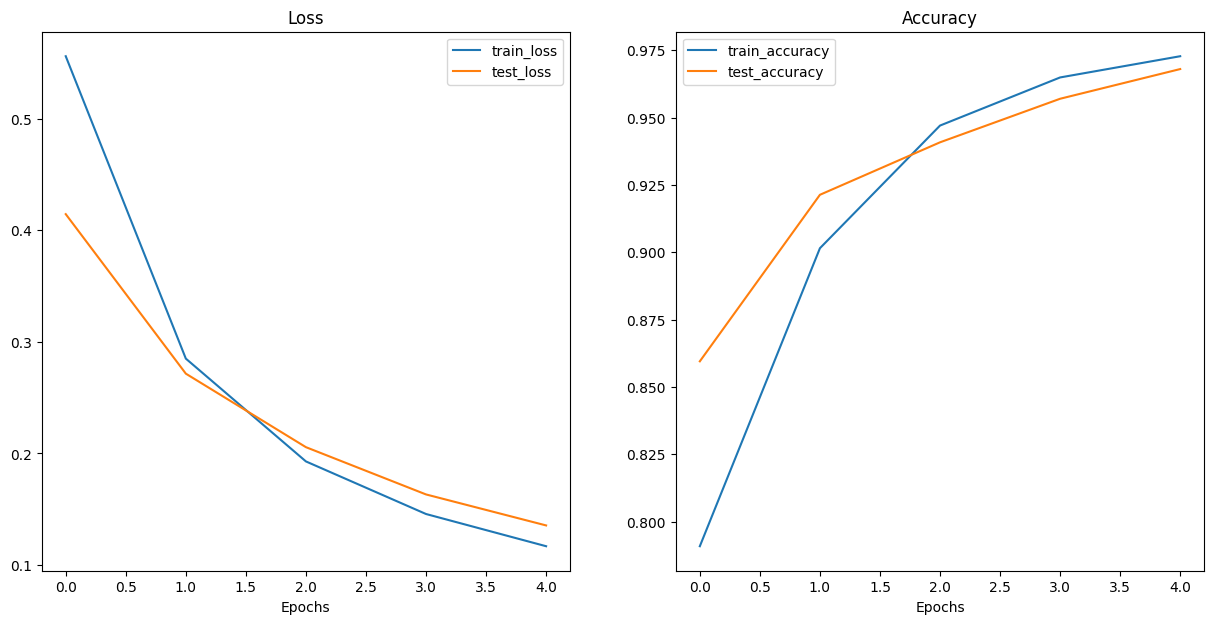

In [29]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)